# Notebook #7: Let's try detecto again...again

So...here we are.  As a reminder to myself, what I'm trying to do at this point is:

1. get a model trained...
1. ...using augmented data...
1. ...actually make a prediction with it...
1. ...and save the model for further use.

In this notebook:

- I'll be using Detecto for training, etc as my wrapper of choice;
- I'll be using the Roboflow images for augmented data.

In future notebooks I'll explore the use of Pytorch Lighting Flash as the wrapper, and Albumentations (and possibly imgaug) for augmented data.

To start with, let's prepare for using this notebook either on a local computer, or in Colab:

# First diversion: getting this working on Paperspace

I ran into issues here when running on Paperspace.  First off, detecto depends on cv2, and cv2 depends on libgl.so.1.  Importing detecto _without_ that library gives `ImportError: libGL.so.1: cannot open shared object file: No such file or directory`.  So, following [the advice here](https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo), I installed libgl-mesa-glx (these notebooks are running on Ubuntu containers):

In [1]:
!apt-get update && apt-get install -y libgl1-mesa-glx

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [109 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Fetched 324 kB in 1s (499 kB/s)  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.2.6-0ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


Next, we need to install detecto:

In [2]:
!pip install detecto

Next, we need to download our dataset:

In [3]:
!rm -rf test train valid README.roboflow.txt

In [9]:
!curl -L "https://app.roboflow.com/ds/foo?key=bar" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1263      0 --:--:-- --:--:-- --:--:--  1262
100 17.3M  100 17.3M    0     0  12.5M      0  0:00:01  0:00:01 --:--:-- 54.4M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/20-09-09-06-51-19-9754_jpg.rf.e60419bcdc9ed39569ebd7cc67df49cf.jpg  
 extracting: test/20-09-09-06-51-19-9754_jpg.rf.e60419bcdc9ed39569ebd7cc67df49cf.xml  
 extracting: test/20-11-30-06-46-08-0275_jpg.rf.adf2988ed6e6b2b0b8c59e6dc2e4565a.jpg  
 extracting: test/20-11-30-06-46-08-0275_jpg.rf.adf2988ed6e6b2b0b8c59e6dc2e4565a.xml  
 extracting: test/20-11-30-07-38-01-0278_jpg.rf.1ec13129ff0ab0851d9c8091bb1c69c4.jpg  
 extracting: test/20-11-30-07-38-01-0278_jpg.rf.1ec13129ff0ab0851d9c8091bb1c69c4.xml  
 extracting: test/20-12-20-12-44-35-0357_jpg.rf.bb8edf932117c95bf2fea4efeefb83d8.j

*Next*, we need to install ipywidgets; otherwise, detecto throws [this error](https://github.com/jupyter-widgets/ipywidgets/issues/2527). After installing the widget, you need to restart the notebook:

In [4]:
!pip install ipywidget

ERROR: Could not find a version that satisfies the requirement ipywidget (from versions: none)
ERROR: No matching distribution found for ipywidget


In [5]:
# Test that it works:
from ipywidgets import IntProgress

*Now* we're ready to prepare for life on Colab, Paperspace, or my home machine:

In [10]:
import os
from pathlib import Path

if 'COLAB_GPU' in os.environ:
    print("I'm running on Colab")
    COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_root = Path('/content/gdrive/MyDrive/dishwasher_training_data/roboflow')
elif 'PAPERSPACE_METRIC_WORKLOAD_TYPE' in os.environ:
    print("I'm running on Paperspace")
    PAPERSPACE = True
    dataset_root = Path('/notebooks') 
else:
    print("Nope, running at home")
    COLAB = False
    dataset_root = Path('/home/aardvark/dev/src/dishwasher_training_data/roboflow')

training = dataset_root/'train/'
test = dataset_root/'test'
valid = dataset_root/'valid'

I'm running on Paperspace


Moving the utility functions up here in order to fribulate an incompletely-annotated dataset.

In [11]:
# https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
import xml.etree.ElementTree as ET

# TODO: Misleading name, odd choice of things to return
# TODO: Find a proper library for VOC stuff
def read_bounding_box_and_labels(xml_file: str):
    """Get the bounding boxes and labels contained within a VOC XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find("filename").text

    for boxes in root.iter("object"):


        xmin, ymin, xmax, ymax = None, None, None, None

        xmin = int(boxes.find("bndbox/xmin").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        name = str(boxes.find("name").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax, name]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

def get_unique_labels_from_xml_file(xml_file: str):
    """Return set() of unique labels from within a VOC XML file
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    unique_labels = set()

    for boxes in root.iter("object"):
        name = boxes.find("name").text
        unique_labels.add(name)

    return unique_labels
        

def get_unique_labels_from_directory(directory: str):
    """Return a list of unique labels from all VOC XML files in a given directory.
    """
    dpath = Path(directory)
    labels = set()
    for f in dpath.glob("*xml"):
        new_set = get_unique_labels_from_xml_file(f)
        labels |= new_set
        
    return list(labels)

Next, let's create a training dataset.

**Note:** [Detecto's quickstart](https://detecto.readthedocs.io/en/latest/usage/quickstart.html) says that you can split data into training & validation folders; however, that does not appear to work for me, and [this docstring](https://github.com/alankbi/detecto/blob/2a22bb660af0c78b9ba7df643afb8dce62b8894c/detecto/core.py#L440-L447) for `Model.fit()` uses the approach I use below (separate datasets for each purpose).

In [30]:
from detecto.core import Dataset, DataLoader

def fribulate_dataset(directory: str):
    """Remove images which don't seem to be annotated.
    """
    dpath = Path(directory)
    fribul_count = 0
    all_count = 0
    for f in dpath.glob("*xml"):
        all_count += 1
        img_filename, boxes = read_bounding_box_and_labels(f)
        if len(boxes) == 0:
            fribul_count += 1
            os.remove(dpath/img_filename)
            os.remove(dpath/f)
    print(f"Fribul count: {fribul_count} / {all_count}")
        

# I've got some images here that have not been annotated yet, so going to try rebuilding things to avoid those.
# If I don't, then I run into exceptions when trying to train the data, or otherwise access members of the dataset. -___-
FRIBULATE_DATASET = True

if FRIBULATE_DATASET is True:
    print("Fribulating dataset!")
    fribulate_dataset(training)
    fribulate_dataset(valid)
            
training_dataset = Dataset(str(training))
validation_dataset = Dataset(str(valid))      

Fribulating dataset!
Fribul count: 0 / 102
Fribul count: 14 / 25


Let's make sure a training image looks good:

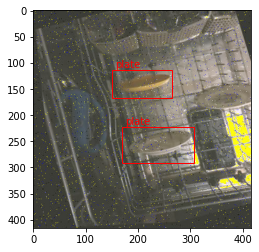

In [31]:
from detecto.visualize import show_labeled_image

image, targets = training_dataset[0]
show_labeled_image(image, targets['boxes'], targets['labels'])

Because I can never remember what I've labelled (still working on this discipline!), I'm including some code here to figure out the labels by examining the VOC files.

In [14]:
labels = get_unique_labels_from_directory(training)
labels

['cup', 'mug', 'plate', 'bowl', 'mixing bowl', 'pot lid', 'pot']

Now let's try training.

(Damn: should have done this:

```python
val_dataset = Dataset('validation_dataset/')
losses = model.fit(dataset, val_dataset, epochs=15, learning_rate=0.01,
                   gamma=0.2, lr_step_size=5, verbose=True)

plt.plot(losses)
plt.show()
```

In [33]:
losses = model.fit(training_dataset, validation_dataset, epochs=15, learning_rate=0.01,
                   gamma=0.2, lr_step_size=5, verbose=True)

plt.plot(losses)
plt.show()

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 2 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 3 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 4 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 5 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 6 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 7 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 8 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 9 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 10 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 11 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 12 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 13 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 14 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Loss: nan
Epoch 15 of 15
Begin iterating over training dataset


  0%|          | 0/11 [00:00<?, ?it/s]

Begin iterating over validation dataset


100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

Loss: nan


NameError: name 'plt' is not defined

In [15]:
from detecto.core import DataLoader, Model

model = Model(labels)
model.fit(training_dataset, verbose=True)

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9 of 10
Begin iterating over training dataset


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 102/102 [00:41<00:00,  2.47it/s]


Okay, model trained (though I forgot the verification dataset, DOH).  Let's see if we can get some predictions with our test dataset:

In [16]:
all_test_imgs = []

for i in test.glob("*jpg"):
    all_test_imgs.append(i)

all_test_imgs

[PosixPath('/notebooks/test/21-03-27-09-03-44-0769_jpg.rf.5f98309b40f02bdfe85d25c2e5955f3c.jpg'),
 PosixPath('/notebooks/test/21-03-26-12-22-40-0740_jpg.rf.b8e06be4021a69f49055d79a1860845c.jpg'),
 PosixPath('/notebooks/test/20-11-30-06-46-08-0275_jpg.rf.adf2988ed6e6b2b0b8c59e6dc2e4565a.jpg'),
 PosixPath('/notebooks/test/20-11-30-07-38-01-0278_jpg.rf.1ec13129ff0ab0851d9c8091bb1c69c4.jpg'),
 PosixPath('/notebooks/test/21-03-25-18-48-35-0721_jpg.rf.de5a296d161b7f4848a5c15e61bb17ea.jpg'),
 PosixPath('/notebooks/test/20-09-09-06-51-19-9754_jpg.rf.e60419bcdc9ed39569ebd7cc67df49cf.jpg'),
 PosixPath('/notebooks/test/21-03-29-18-41-11-0805_jpg.rf.e982197486b2a83c23c0d9563555a4d8.jpg'),
 PosixPath('/notebooks/test/21-03-26-12-22-26-0737_jpg.rf.fcb9e594be7e16f6d7e87edc0a91935f.jpg'),
 PosixPath('/notebooks/test/21-03-26-12-25-57-0755_jpg.rf.c0b28f4fd73c7b50652d3eff4bdd6613.jpg'),
 PosixPath('/notebooks/test/21-03-27-09-03-50-0771_jpg.rf.d0ffb31fb0116e697be6266656585ee1.jpg'),
 PosixPath('/noteboo

In [34]:
from detecto.utils import read_image
test_image = read_image(str(all_test_imgs[1]))

predicted_labels, predicted_boxes, predicted_confidence = model.predict_top(test_image)

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

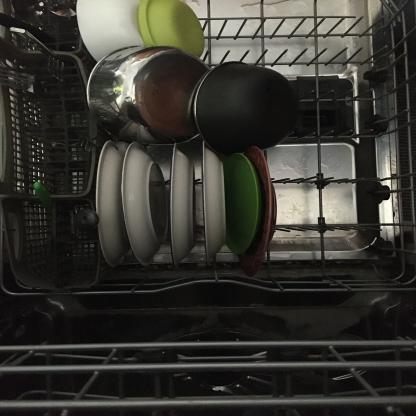

In [29]:
test_image
from IPython.display import Image
Image(filename=all_test_imgs[1])

In [27]:
model.predict(all_test_imgs[0])

TypeError: pic should be PIL Image or ndarray. Got <class 'pathlib.PosixPath'>

In [35]:
ptorch_model = model._model

In [40]:
import torch

prediction = ptorch_model(torch.from_numpy(test_image))

ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([416, 3])

In [18]:
from detecto.visualize import show_labeled_image

show_labeled_image(test_image, predicted_boxes, predicted_labels)

NameError: name 'predicted_boxes' is not defined

Not bad!  What about the second one?

In [ ]:
test_image_2 = read_image(str(all_test_imgs[1]))
predicted_labels_2, predicted_boxes_2, predicted_confidence_2 = model.predict_top(test_image_2)
show_labeled_image(test_image_2, predicted_boxes_2, predicted_labels_2)

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

#  🤣

In [ ]:
model.save('./notebook_7-detecto_roboflow-trained_so_quickly_zomg_on_paperspace-thats_paperspace_dot_com-use_referral_code_OMGPONIES.pth')

In [ ]:
!ls -l 

total 324779
-rw-r--r-- 1 root root      3171 Mar 25 22:59 '01 Learn the Basics.ipynb'
-rw-r--r-- 1 root root     14196 Mar 25 22:59 '02 Quickstart Tutorial.ipynb'
-rw-r--r-- 1 root root     17399 Mar 25 22:59 '03 Tensors.ipynb'
-rw-r--r-- 1 root root     13251 Mar 25 22:59 '04 Datasets & DataLoaders.ipynb'
-rw-r--r-- 1 root root      4458 Mar 25 22:59 '05 Transforms.ipynb'
-rw-r--r-- 1 root root     12258 Mar 25 23:00 '06 Build a Model.ipynb'
-rw-r--r-- 1 root root     13820 Mar 25 22:59 '07 Autograd.ipynb'
-rw-r--r-- 1 root root     12132 Mar 25 22:59 '08 Optimization.ipynb'
-rw-r--r-- 1 root root      6021 Mar 25 22:59 '09 Save & Load Model.ipynb'
-rw-r--r-- 1 root root       880 Mar 25 23:47  README.roboflow.txt
-rw-r--r-- 1 root root        72 Mar 25 23:00  Untitled.ipynb
-rw-r--r-- 1 root root 165835406 Mar 25 23:14  notebook_6-detecto_roboflow-trained_so_quickly_zomg_on_paperspace-thats_paperspace_dot_com-use_referral_code_OMGPONIES.pth
-rw-r--r-- 1 root root    416149 Mar 25 23

Gotta figure out how to do this sort of thing consistently...but for now, we'll stick with that.

# Next steps

- ~~Load this model from the rest api~~
  - In predict.py as MODEL_6
- ~~Code to draw the image with bounding boxes, suitable for serving with the rest API~~
  - Done; see `draw_bounding_boxes()` in transforms.py
- Display that properly in results page
  - **NOT WORKING**.  See comment in transforms.py.

In [ ]:
# 